<CENTER>
    <a href="http://opendata.atlas.cern" class="icons"><img src="../Assets/ATLASOD.gif" style="width:50%"></a>
</CENTER>

<CENTER><h1>Searching for the Higgs boson in the H&#8594;&gamma;&gamma; channel</h1></CENTER>
## C++ notebook example

**Introduction**
Let's take a current ATLAS Open Data sample and create a histogram:

In order to activate the interactive visualisation of the histogram that is later created we can use the JSROOT magic:

In [1]:
//%jsroot on

We need to include some standard C++ and ROOT libraries

In [2]:
// Creates a TChain to be used by the Analysis.C class
#include <TChain.h>
#include <vector>
#include <TFile.h>
#include <iostream>
#include <string>
#include <stdio.h>

Because we would like to use more than one ROOT input file, the best option is to use a TChain object. This allows to "chain" several samples into a single structure that we can later loop over

In [3]:
TString path = "http://opendata.atlas.cern/release/samples/2019/GamGam/"

(TString &) @0x7f41128d6028


In [4]:
TChain* fChain = new TChain("mini");

fChain->AddFile(path+"Data/dataA_yy.root");
fChain->AddFile(path+"Data/dataB_yy.root");
fChain->AddFile(path+"Data/dataC_yy.root");
fChain->AddFile(path+"Data/dataD_yy.root");
fChain->AddFile(path+"Data/data302737-303338_yy.root");
fChain->AddFile(path+"Data/data303421-303560_yy.root");

Now we're going to extract the photons variables

In [5]:
UInt_t  Photon_n = -1;      //number of preselected photons

vector<float>   *Photon_pt;    //transverse momentum of the photon
vector<float>   *Photon_eta = 0;    //pseudorapidity of the photon
vector<float>   *Photon_phi = 0;    //azimuthal angle of the photon
vector<float>   *Photon_E   = 0;    //energy of the photon
vector<bool>    *Photon_isTightID = 0;

Bool_t          TrigP = 0;
vector<float>   *Photon_ptcone30 = 0;
vector<float>   *Photon_etcone20 = 0;

Here we're filling the variables defined above with the content of those inside the input ntuples

In [6]:
fChain->SetBranchAddress("photon_pt",        &Photon_pt);  
fChain->SetBranchAddress("photon_n",         &Photon_n);  

fChain->SetBranchAddress("photon_eta",       &Photon_eta);
fChain->SetBranchAddress("photon_phi",       &Photon_phi);
fChain->SetBranchAddress("photon_E",         &Photon_E);
fChain->SetBranchAddress("photon_isTightID", &Photon_isTightID);

fChain->SetBranchAddress("trigP",            &TrigP);
fChain->SetBranchAddress("photon_ptcone30",  &Photon_ptcone30);
fChain->SetBranchAddress("photon_etcone20",  &Photon_etcone20);

We're creating a histogram for this example. The plan in to fill them with events.

In [7]:
//Invariant mass histograms definition
TH1F *h_M_Hyy = new TH1F("h_M_Hyy","Invariant Mass of the Higgs boson ; mass [GeV] ; events",50,80,280);

We are selecting below a simple look for them.

In [8]:
h_M_Hyy->SetMarkerSize(2.0);
h_M_Hyy->SetLineColor(kBlue);
h_M_Hyy->SetFillColor(kBlue-10);

The Higgs boson analysis implemented here considers Higgs boson decays into a proton-proton pair. The event selection criteria are:

In [9]:
int nentries, nbytes, i;
nentries = (Int_t)fChain->GetEntries();

std::cout << "Total number of entries to analyze: " << nentries << std::endl;

// Preselection of good photons

for (i=0; i < nentries; i++)
{
    nbytes =  fChain->GetEntry(i);
    
    //# Cut: Diphoton trigger is satisfied
    if(TrigP)
    {
        int goodphoton_index[5]; // give the vector a size good enough to avoid segmentation faults due to events with more than 2 photons.
        int goodphoton_n = 0;    // the total number of good photon
        int photon_index = 0;
        
        for(unsigned int j=0; j<Photon_n; j++)
        {
            // photons are tight
            if(Photon_isTightID->at(j))
            {
                //# Cut: two photons with 25 GeV and excluding the transition region between the barrel and endcap calorimeters
                if(Photon_pt->at(j) >25000. && TMath::Abs(Photon_eta->at(j)<2.37) && 
                   (TMath::Abs(Photon_eta->at(j) < 1.37) || TMath::Abs(Photon_eta->at(j) > 1.52)))
                {
                    goodphoton_n = goodphoton_n + 1;  // count
                    goodphoton_index[photon_index] = j;
                    photon_index++;
                }
            }
        }

        //# Cut: Exactly two photons   
        if(goodphoton_n==2)
        {
            int goodphoton1_index = goodphoton_index[0];
            int goodphoton2_index = goodphoton_index[1];
            // isolated photons
            if(((Photon_ptcone30->at(goodphoton1_index)/Photon_pt->at(goodphoton1_index)) < 0.065) && ((Photon_etcone20->at(goodphoton1_index) / Photon_pt->at(goodphoton1_index)) < 0.065 ))
            {
                if(((Photon_ptcone30->at(goodphoton2_index)/Photon_pt->at(goodphoton2_index)) < 0.065) && ((Photon_etcone20->at(goodphoton2_index) / Photon_pt->at(goodphoton2_index)) < 0.065 ))
                {
                    // TLorentzVector definitions
                    TLorentzVector Photon_1  = TLorentzVector();
                    TLorentzVector Photon_2  = TLorentzVector();
                    
                    Photon_1.SetPtEtaPhiE(Photon_pt->at(goodphoton1_index), Photon_eta->at(goodphoton1_index), Photon_phi->at(goodphoton1_index),Photon_E->at(goodphoton1_index));
                    Photon_2.SetPtEtaPhiE(Photon_pt->at(goodphoton2_index), Photon_eta->at(goodphoton2_index), Photon_phi->at(goodphoton2_index),Photon_E->at(goodphoton2_index));
                    
                    float dPhi_yy = fabs(Photon_phi->at(goodphoton1_index) - Photon_phi->at(goodphoton2_index));
                    dPhi_yy       = dPhi_yy < TMath::Pi() ? dPhi_yy : 2*TMath::Pi() - dPhi_yy;
                    float m_yy    = sqrt( 2 * Photon_1.Pt() * Photon_2.Pt() * 
                                      (cosh( Photon_1.Eta() - Photon_2.Eta()) - cos(dPhi_yy)));
                    
                    //Calculation of the Invariant Mass using TLorentz vectors
                    TLorentzVector Photon_12 = Photon_1 + Photon_2;
                    float mass_inv_GeV = Photon_12.M()/1000.;
                    
                    h_M_Hyy->Fill(mass_inv_GeV);
                }
            }
        }
    } // end TrigPhoton request
}

std::cout << "Analysed a total of: " << nentries << " in this sample." << std::endl;

Total number of entries to analyze: 11400626
Analysed a total of: 11400626 in this sample.


TClass::Init:0: RuntimeWarning: no dictionary for class ROOT::TIOFeatures is available


#### Final plot

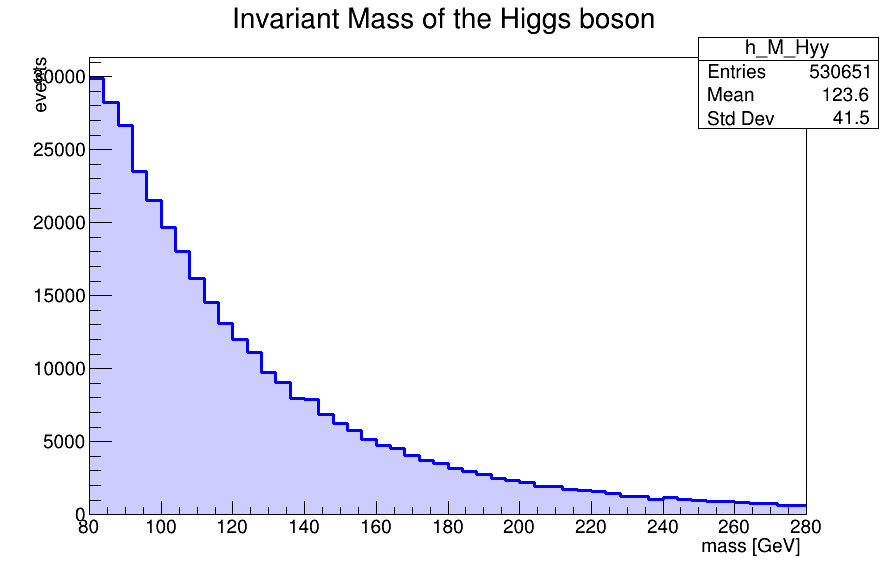

In [10]:
TCanvas *cz = new TCanvas("cz","cz",10,10,900,600);
TText tz; tz.SetTextFont(42); tz.SetTextAlign(21);
h_M_Hyy->Draw();
cz->Draw();

#### Log Scale

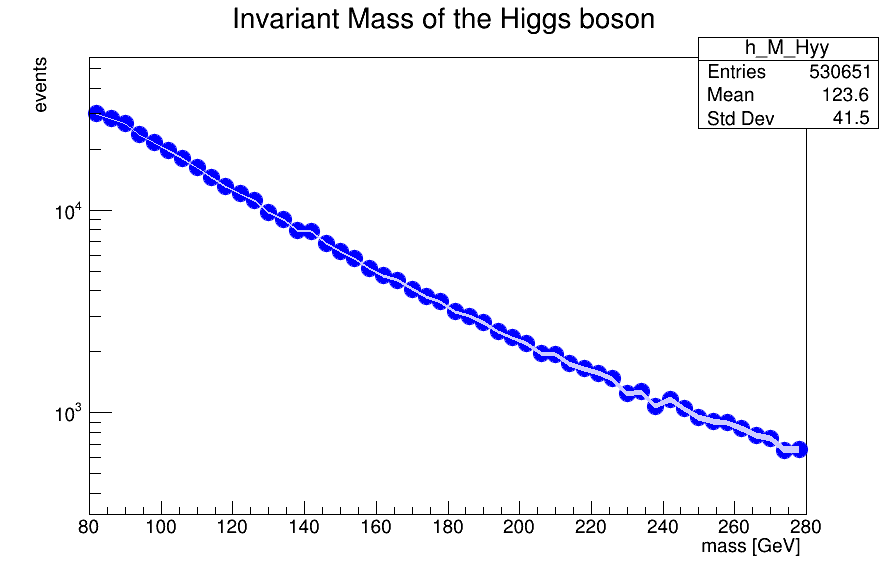

In [11]:
h_M_Hyy->Draw("E3");
cz->SetLogy();
cz->Draw();